<a href="https://colab.research.google.com/github/Nathan-Ketterlinus/LorenzDNN/blob/main/Lorenz_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde
import deepxde as dde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.1 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Generating reference solution 0/1000
Generating reference solution 100/1000
Generating reference solution 200/1000
Generating reference solution 300/1000
Generating reference solution 400/1000
Generating reference solution 500/1000
Generating reference solution 600/1000
Generating reference solution 700/1000
Generating reference solution 800/1000
Generating reference solution 900/1000


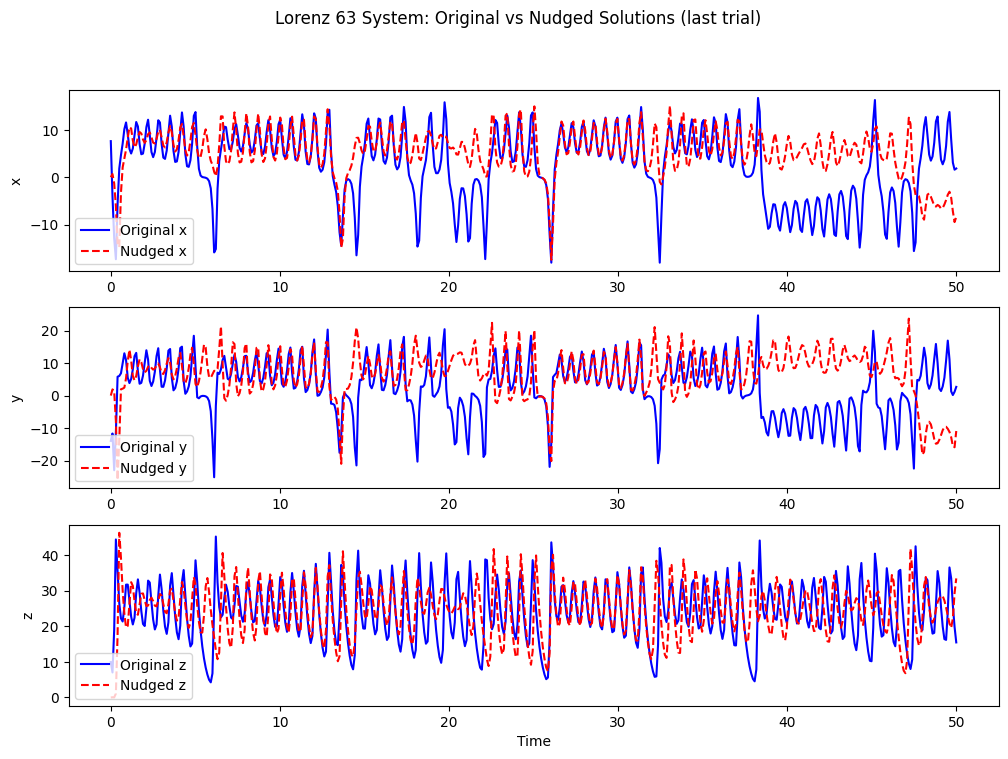

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


class Lorenz63:
    def __init__(self, sigma=10.0, rho=28.0, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def original_system(self, state, t):
        x, y, z = state

        # system equations
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z

        return [dxdt, dydt, dzdt]

    def nudged_system(self, state, t, x_observed, mu):
        x_bar, y_bar, z_bar = state

        # Get the observed x value at time t (needs interpolation)
        x = np.interp(t, x_observed[:, 0], x_observed[:, 1])

        # system equations
        dxdt_bar = self.sigma * (y_bar - x_bar) - mu * (x_bar - x) # with nudging term!
        dydt_bar = x_bar * (self.rho - z_bar) - y_bar
        dzdt_bar = x_bar * y_bar - self.beta * z_bar

        return [dxdt_bar, dydt_bar, dzdt_bar]

def simulate_lorenz_with_nudging():
    # Parameters
    sigma = 10.0
    rho = 28.0
    beta = 8/3
    mu = 30  # Nudging parameter

    num_reference_solutions = 1000  # N_s
    final_time = 50  # T, when to stop simulation (in seconds)
    observations_per_second = 10
    observation_times = np.linspace(0, final_time, final_time * observations_per_second) # {t_n}

    input_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar, observed x) @ time t
    output_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar) @ time t+1

    for i in range(num_reference_solutions):
        # Display progress of generating solutions
        if i % 100 == 0:
            print(f"Generating reference solution {i}/{num_reference_solutions}")

        # Generate random initial conditions
        x0, y0, z0 = np.random.normal(loc=0, scale=10, size=3) # from mean = 0, std dev =10

        # Simulate true system
        lorenz = Lorenz63(sigma, rho, beta)
        true_solution = odeint(lorenz.original_system, [x0, y0, z0], observation_times)

        # Create observations (x-component only)
        x_observed = np.column_stack((observation_times, true_solution[:, 0])) # I_M(u^i(t_k))

        # Simulate nudged system
        nudged_solution = odeint(lorenz.nudged_system, [0, 0, 0], observation_times, args=(x_observed, mu)) # W^i(t_k)

        # Create training pairs (Algorithm 3.1)
        for k in range(len(observation_times) - 1):
            # Input: [w(t_k), I_M(u(t_k))]
            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            input_pair = np.concatenate([current_state, [current_obs]])

            # Output: w(t_{k+1})
            next_state = nudged_solution[k + 1]

            input_samples.append(input_pair)
            output_samples.append(next_state)

    # Convert to numpy arrays
    input_data = np.array(input_samples)
    output_data = np.array(output_samples)

    # Plot results
    plt.figure(figsize=(12, 8))

    # Plot x components
    plt.subplot(3, 1, 1)
    plt.plot(observation_times, true_solution[:, 0], 'b-', label='Original x')
    plt.plot(observation_times, nudged_solution[:, 0], 'r--', label='Nudged x')
    plt.ylabel('x')
    plt.legend()

    # Plot y components
    plt.subplot(3, 1, 2)
    plt.plot(observation_times, true_solution[:, 1], 'b-', label='Original y')
    plt.plot(observation_times, nudged_solution[:, 1], 'r--', label='Nudged y')
    plt.ylabel('y')
    plt.legend()

    # Plot z components
    plt.subplot(3, 1, 3)
    plt.plot(observation_times, true_solution[:, 2], 'b-', label='Original z')
    plt.plot(observation_times, nudged_solution[:, 2], 'r--', label='Nudged z')
    plt.ylabel('z')
    plt.xlabel('Time')
    plt.legend()

    plt.suptitle('Lorenz 63 System: Original vs Nudged Solutions (last trial)')
    plt.show()

    return input_data, output_data

# Run the simulation
original, nudged = simulate_lorenz_with_nudging()

timedomain = dde.geometry.TimeDomain(0, 10)

############################################################
# Algorithm 3.2: Online Usage of DNN for Data Assimilation #
############################################################
# 1: Initialize wDNN (t0) = 0 (or arbitrary)               #
# 2: Observe IM (ui(t0))                                   #
# 3: Set k = 0                                             #
# 4: while Observations are available do                   #
# 5:      wDNN (tk+1) = DNN (wDNN (tk), IM (ui(tk))        #
# 6:      Observe IM (ui(tk+1))                            #
# 7:      k = k + 1                                        #
# 8: end while                                             #
############################################################

===== Versions =====
dde: 1.14.0
np: 2.1.3
tf: 2.19.0
tf.keras: 3.10.0
===== Simulating Lorenz Model with Nudging =====
Observation times from t=100.0 to 110.0 with 101 points
Time between observations: 0.09999999999999432 (should be 0.1)
Generating reference solution for initial condition 0/1000
Generating reference solution for initial condition 100/1000
Generating reference solution for initial condition 200/1000
Generating reference solution for initial condition 300/1000
Generating reference solution for initial condition 400/1000
Generating reference solution for initial condition 500/1000
Generating reference solution for initial condition 600/1000
Generating reference solution for initial condition 700/1000
Generating reference solution for initial condition 800/1000
Generating reference solution for initial condition 900/1000


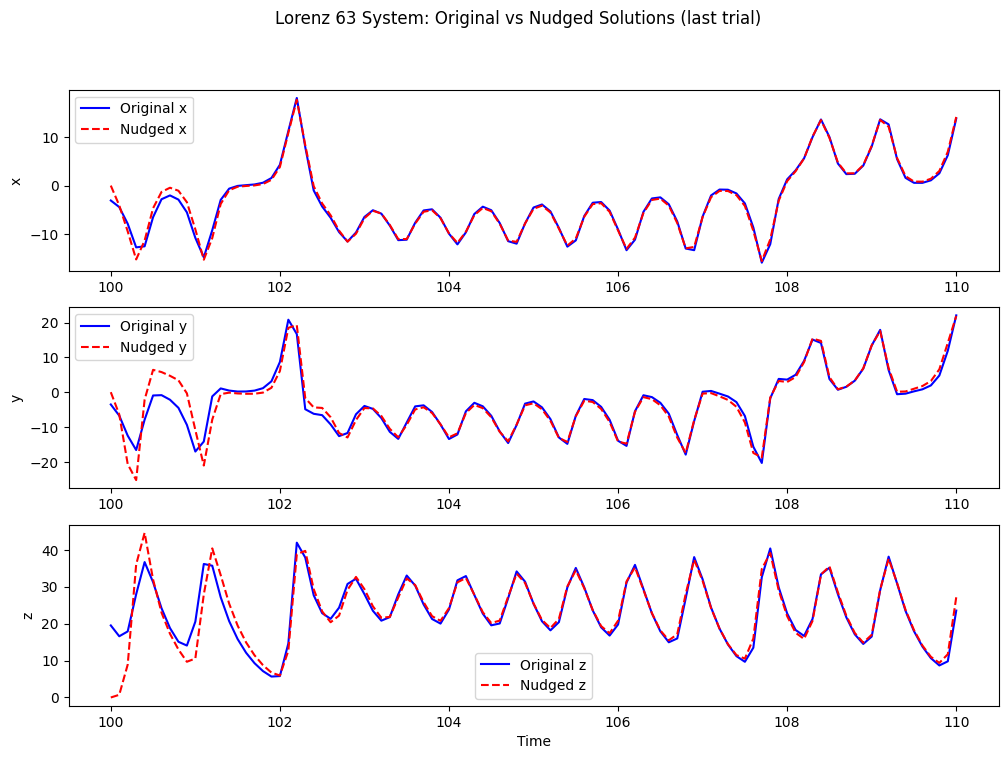


=== Verification ===
Number of initial conditions (Ns): 1000
Observations per simulation: 100 (from 101 time points)
Expected total samples: 100000 (Ns × 100)
Actual input_data shape: (100000, 4) (should be (100000, 4))
Actual output_data shape: (100000, 3) (should be (100000, 3))
Compiling model...
Building feed-forward neural network...
'build' took 0.086160 s

'compile' took 0.355741 s

Training model...

Step      Train loss    Test loss     Test metric
0         [2.76e+02]    [nan]         []  

Best model at step 0:
  train loss: 2.76e+02
  test loss: nan
  test metric: []

'train' took 0.555213 s

Compiling model...
'compile' took 0.218630 s

Training model...

Step      Train loss    Test loss     Test metric
1         [2.64e+02]    [nan]         []  
17        [2.64e+02]    [nan]         []  

Best model at step 1:
  train loss: 2.64e+02
  test loss: nan
  test metric: []

'train' took 0.897348 s



(<deepxde.model.LossHistory at 0x7f1b6bb38d10>,
 <deepxde.model.TrainState at 0x7f1b60747a10>)

In [9]:
import deepxde as dde
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

print("===== Versions =====")
print("dde: " + dde.__version__)
print("np: " + np.__version__)
#print(odeint.__version__)
#print(plt.__version__)
print("tf: " +tf.__version__)
print("tf.keras: " + tf.keras.__version__)


class Lorenz63:
    def __init__(self, sigma=10.0, rho=28.0, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def original_system(self, state, t):
        x, y, z = state

        # system equations
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z

        return [dxdt, dydt, dzdt]

    def nudged_system(self, state, t, x_observed, mu):
        x_bar, y_bar, z_bar = state

        # Get the observed x value at time t (needs interpolation)
        x = np.interp(t, x_observed[:, 0], x_observed[:, 1])

        # system equations
        dxdt_bar = self.sigma * (y_bar - x_bar) - mu * (x_bar - x) # with nudging term!
        dydt_bar = x_bar * (self.rho - z_bar) - y_bar
        dzdt_bar = x_bar * y_bar - self.beta * z_bar

        return [dxdt_bar, dydt_bar, dzdt_bar]

def simulate_lorenz_with_nudging():
    # Parameters
    sigma = 10.0
    rho = 28.0
    beta = 8/3
    mu = 30  # Nudging parameter

    num_reference_solutions = 1000  # N_s
    total_simulation_time = 110  # Simulate up to t=110
    observation_start_time = 100  # Start recording observations at t=100
    observations_per_time_unit = 10  # δ = 0.1 time units between observations
    delta_t = 1.0/observations_per_time_unit  # 0.1

    # Create observation times (from 100 to 110, every 0.1 units)
    num_observations = int((total_simulation_time - observation_start_time) / delta_t) + 1
    observation_times = np.linspace(observation_start_time, total_simulation_time, num_observations)

    # Verify observation times

    print("===== Simulating Lorenz Model with Nudging =====")
    print(f"Observation times from t={observation_times[0]} to {observation_times[-1]} with {len(observation_times)} points")
    print(f"Time between observations: {observation_times[1] - observation_times[0]} (should be {delta_t})")

    # Full simulation times (from 0 to 110 - needed for the ODE solver)
    full_simulation_times = np.linspace(0, total_simulation_time,
                                       int(total_simulation_time * observations_per_time_unit) + 1)

    input_samples = [] # stores (x_bar, y_bar, z_bar, observed x) @ time t
    output_samples = [] # stores (x_bar, y_bar, z_bar) @ time t+1

    for i in range(num_reference_solutions):
        # Display progress of generating solutions
        if i % 100 == 0:
            print(f"Generating reference solution for initial condition {i}/{num_reference_solutions}")

        # Generate random initial conditions from N(0, 10)
        x0, y0, z0 = np.random.normal(loc=0, scale=10, size=3)

        # Simulate true system from t=0 to t=110
        lorenz = Lorenz63(sigma, rho, beta)
        true_solution = odeint(lorenz.original_system, [x0, y0, z0], full_simulation_times)

        # Extract only the observation period (t=100 to t=110)
        obs_indices = (full_simulation_times >= observation_start_time)
        observed_times = full_simulation_times[obs_indices]
        observed_states = true_solution[obs_indices]

        # Verify we have correct number of observation points
        assert len(observed_times) == num_observations, \
               f"Expected {num_observations} observations, got {len(observed_times)}"

        # Create observations (x-component only) during observation period
        x_observed = np.column_stack((observed_times, observed_states[:, 0]))

        # Simulate nudged system during observation period only
        nudged_solution = odeint(lorenz.nudged_system, [0, 0, 0], observed_times, args=(x_observed, mu))

        # Create training pairs (Algorithm 3.1)
        for k in range(len(observed_times) - 1):
            # Input: [w(t_k), I_M(u(t_k))]
            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            input_pair = np.concatenate([current_state, [current_obs]])

            # Output: w(t_{k+1})
            next_state = nudged_solution[k + 1]

            input_samples.append(input_pair)
            output_samples.append(next_state)

    # Convert to numpy arrays
    input_data = np.array(input_samples)
    output_data = np.array(output_samples)

    # Plot results
    plt.figure(figsize=(12, 8))

    # Extract the portion of true_solution corresponding to observation_times
    true_solution_obs_period = true_solution[obs_indices]

    # Plot x components
    plt.subplot(3, 1, 1)
    plt.plot(observation_times, true_solution_obs_period[:, 0], 'b-', label='Original x')
    plt.plot(observation_times, nudged_solution[:, 0], 'r--', label='Nudged x')
    plt.ylabel('x')
    plt.legend()

    # Plot y components
    plt.subplot(3, 1, 2)
    plt.plot(observation_times, true_solution_obs_period[:, 1], 'b-', label='Original y')
    plt.plot(observation_times, nudged_solution[:, 1], 'r--', label='Nudged y')
    plt.ylabel('y')
    plt.legend()

    # Plot z components
    plt.subplot(3, 1, 3)
    plt.plot(observation_times, true_solution_obs_period[:, 2], 'b-', label='Original z')
    plt.plot(observation_times, nudged_solution[:, 2], 'r--', label='Nudged z')
    plt.ylabel('z')
    plt.xlabel('Time')
    plt.legend()

    plt.suptitle('Lorenz 63 System: Original vs Nudged Solutions (last trial)')
    plt.show()

    # Verification
    print("\n=== Verification ===")
    print(f"Number of initial conditions (Ns): {num_reference_solutions}")
    print(f"Observations per simulation: {num_observations - 1} (from {num_observations} time points)")
    expected_total_samples = num_reference_solutions * (num_observations - 1)
    print(f"Expected total samples: {expected_total_samples} (Ns × {num_observations - 1})")
    print(f"Actual input_data shape: {input_data.shape} (should be ({expected_total_samples}, 4))")
    print(f"Actual output_data shape: {output_data.shape} (should be ({expected_total_samples}, 3))")

    assert input_data.shape == (expected_total_samples, 4), "Input data shape mismatch"
    assert output_data.shape == (expected_total_samples, 3), "Output data shape mismatch"

    return input_data, output_data

# Run the simulation
input_data, output_data = simulate_lorenz_with_nudging()

# crop to just the first N x N_s samples
N = 15
num_reference_solutions = 1000 # Define N_s here
input_data = input_data[:num_reference_solutions * N]
output_data = output_data[:num_reference_solutions * N]

############################################################
# Algorithm 3.2: Online Usage of DNN for Data Assimilation #
############################################################
# 1: Initialize wDNN (t0) = 0 (or arbitrary)               #
# 2: Observe IM (ui(t0))                                   #
# 3: Set k = 0                                             #
# 4: while Observations are available do                   #
# 5:      wDNN (tk+1) = DNN (wDNN (tk), IM (ui(tk))        #
# 6:      Observe IM (ui(tk+1))                            #
# 7:      k = k + 1                                        #
# 8: end while                                             #
############################################################

# 1. Prepare data
X = np.array(input_data, dtype=np.float32)  # shape (15000, 4)
Y = np.array(output_data, dtype=np.float32) # shape (15000, 3)

assert X.shape[1] == 4, "input_data must have 4 columns (x,y,z,t)"
assert Y.shape[1] == 3, "output_data must have 3 columns (x,y,z)"

# 2. Supervised dataset
data = dde.data.DataSet(
    X_train=X,
    y_train=Y,
    X_test=np.array([], dtype=np.float32).reshape(0, X.shape[1]),
    y_test=np.array([], dtype=np.float32).reshape(0, Y.shape[1]),
)

# 3. Define residual FNN
net = dde.maps.FNN(
    layer_sizes=[4] + [50] * 3 + [3],
    activation="relu",
    kernel_initializer="Glorot normal"
)

# 4. Model
model = dde.Model(data, net)

# 5. Compile
model.compile(
    optimizer="adam",
    lr=1e-3,
    loss="mse",
)

# 6. Train
losshistory, train_state = model.train(
    epochs=20000,
    batch_size=64,
    display_every=1000,
    callbacks=[
        dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
    ]
)

# 7. Save model
model.save("lorenz63_dnn_model")

# Optional: fine-tune with L-BFGS
model.compile("L-BFGS", loss="mse")
model.train()